In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# High Order Derivatives

In this notebook you will learn how to solve PDEs that involve higher order derivatives. We want to solve the following PDE:

\begin{equation}
    u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = \Gamma (\phi_{xx} + \phi_{yy}) 
\end{equation}

The independen variables, $x$ and $y$, are used as input values for the NN, and the solution (i.e. $\phi(x,y)$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs to obtain the first order derivatives. The same is done for the gradients to obtain the second order derivatives. Then, a loss function that matches the PDE is built and the weights are updated accordingly. A loss function that matches the PDE is then used for optimization. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. The geometry of the problem is as follows:

![sh](pics/sh.png)

In [2]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import nangs
import math

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.05', '1.10.0')

In [3]:
from nangs import PDE

TAU = 0.001
ALPHA = 10

# velocity field
vel = lambda x, y: (2*y*(1-x**2), -2*x*(1-y**2))

class SH(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute first-order derivatives
        grads = self.computeGrads(outputs, inputs)       
        dpdx, dpdy = grads[:, 0], grads[:, 1]
        
        # compute second-order derivatives
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0]        
        dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        
        # compute loss
        x, y = inputs[:, 0], inputs[:, 1]
        u, v = vel(x, y)
        return {'pde': u*dpdx + v*dpdy - TAU*(dp2dx2 + dp2dy2)}


# instanciate pde
pde = SH(inputs=('x', 'y'), outputs='p')

In [4]:
# define the sampler

from nangs import RandomSampler

n_samples = 100
sampler = RandomSampler({
    'x': [-1., 1.], 
    'y': [0., 1.], 
}, device=device, n_samples=n_samples)

pde.set_sampler(sampler)

In [5]:
from nangs import Dirichlet

n_samples = 100
left = Dirichlet(
    RandomSampler({'x': -1, 'y': [0., 1.]}, device=device, n_samples=n_samples), 
    lambda inputs: {'p' : torch.ones(n_samples, device=inputs['x'].device)*(1. - math.tanh(ALPHA))},
    name="left"
)

pde.add_boco(left)

In [6]:
right = Dirichlet(
    RandomSampler({'x': 1, 'y': [0., 1.]}, device=device, n_samples=n_samples), 
    lambda inputs: {'p' : torch.ones(n_samples, device=inputs['x'].device)*(1. - math.tanh(ALPHA))},
    name="right"
)

pde.add_boco(right)

In [7]:
# top b.c 

top = Dirichlet(
    RandomSampler({'x': [-1., 1.], 'y': 1.}, device=device, n_samples=n_samples), 
    lambda inputs: {'p' : torch.ones(n_samples, device=inputs['x'].device)*(1. - math.tanh(ALPHA))},
    name="top"
)

pde.add_boco(top)


In [8]:
# bottom b.c

bot_left = Dirichlet(
    RandomSampler({'x': [-1., 0.], 'y': 0.}, device=device, n_samples=n_samples), 
    lambda inputs: {'p' : 1. + torch.tanh(ALPHA*(2*inputs['x']+1))},
    name="bot-left"
)

pde.add_boco(bot_left)

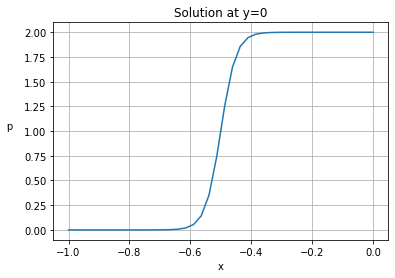

In [9]:
x = np.linspace(-1, 0, 40)
p = 1. + np.tanh(ALPHA*(2.*x + 1.))

plt.plot(x, p)
plt.xlabel('x')
plt.ylabel('p      ', rotation=np.pi/2)
plt.title('Solution at y=0')
plt.grid()
plt.show()

In [10]:
# bottom right b.c

from nangs import Neumann

class MyNeumann(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        dpdy = self.computeGrads(outputs, inputs)[:, 1]
        return {'gradY': dpdy}

bot_right = MyNeumann(
    RandomSampler({'x': [0., 1.], 'y': 0.}, device=device, n_samples=n_samples), 
    name='bot-right'
)

pde.add_boco(bot_right)

In [11]:
from nangs import MLP

LR = 3e-4
N_STEPS = 10000
NUM_LAYERS = 5
NUM_HIDDEN = 100

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer)
%time hist = pde.solve(N_STEPS, log_each=100)

{'pde': 0.00014, 'left': 0.0, 'right': 1e-05, 'top': 1e-05, 'bot-left': 2e-05, 'bot-right_gradY': 1e-05}: 100%|██████████| 10000/10000 [01:36<00:00, 103.73it/s]

CPU times: user 1min 35s, sys: 764 ms, total: 1min 36s
Wall time: 1min 36s


<AxesSubplot:>

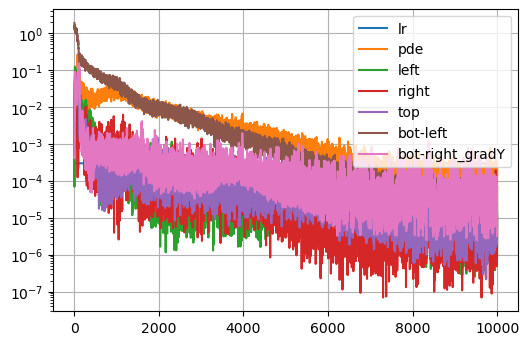

In [12]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

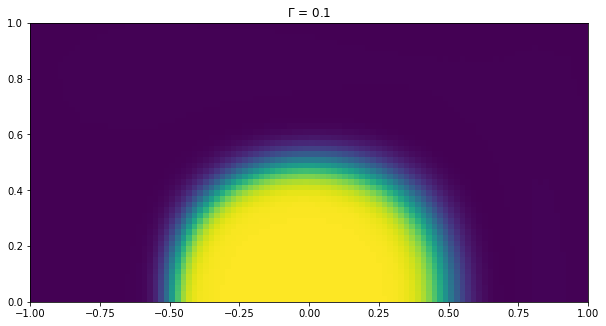

In [13]:
# evaluate the solution
#pde.load_state_dict('best.pth')

x = np.linspace(-1,1,100)
y = np.linspace(0,1,50)

grid = np.stack(np.meshgrid(x, y), -1).reshape(-1, 2)
X = torch.from_numpy(grid).float().to(device)

p = pde.eval(X).cpu().view(len(y),len(x)).numpy()

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(p, vmin=p.min(), vmax=p.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
ax.set_title(f"$\\Gamma$ = 0.1")
plt.show()

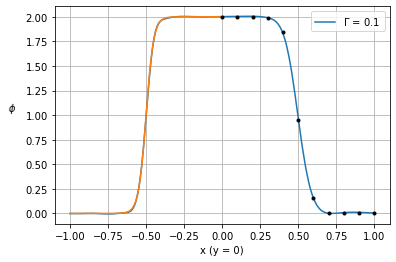

In [14]:
# experimental results

exp = {
    'x': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'g_0.1': [1.989,1.402,1.146,0.946,0.775,0.621,0.480,0.349,0.227,0.111,0.0],
    'g_0.001': [2.0000,1.9990,1.9997,1.985,1.841,0.951,0.154,0.001,0.0,0.0,0.0],
    'g_0.000001': [2.0000,2.0,2.0,1.999,1.964,1.0,0.036,0.001,0.0,0.0,0.0]
}

x = np.linspace(-1,1,200)
y = np.array([0])

grid = np.stack(np.meshgrid(x, y), -1).reshape(-1, 2)
X = torch.from_numpy(grid).float().to(device)

p = pde.eval(X).cpu().numpy().reshape(len(x))

plt.plot(x, p, label=f"$\\Gamma$ = 0.1")

p1 = 1. + np.tanh(ALPHA*(2*x[x<0]+1))
plt.plot(x[x<0], p1)

plt.plot(exp['x'], exp['g_0.001'], '.k')
plt.grid()
plt.xlabel('x (y = 0)')
plt.ylabel('$\\phi$       ', rotation=np.pi/2)
plt.legend()
plt.show()